# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [6]:
import pandas as pd
import numpy as np
import math
import time
import json
# % matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration

#### Portfolio Dataset

In [7]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [8]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


<AxesSubplot:title={'center':'Distribution of Offer Type'}>

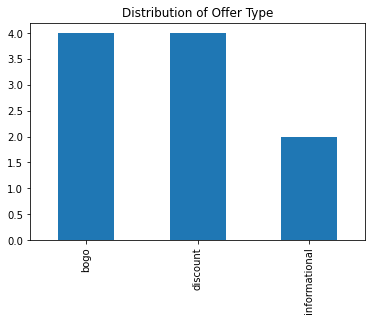

In [9]:
pd.value_counts(portfolio['offer_type']).plot.bar(title='Distribution of Offer Type')

<AxesSubplot:title={'center':'Distribution of Duration'}>

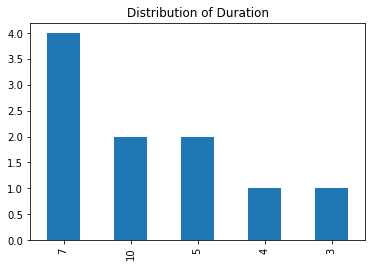

In [10]:
pd.value_counts(portfolio['duration']).plot.bar(title='Distribution of Duration')

**Observations**

* From the above frequency charts, it is observed that BOGO and Discount are the most prevelant offer types in the portfolio datasets. 
* 7 days is the highest number of occurences for the number of days the offers are going to be live in the market

#### Profile Dataset

In [11]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [12]:
profile.describe(include="all")

,gender,age,id,became_member_on,income
count,14825,17000.000000,17000,1.700000e+04,14825.000000
unique,3,NaN,17000,NaN,NaN
top,M,NaN,019cc78d8fed432ca6df71c132c72a99,NaN,NaN
freq,8484,NaN,1,NaN,NaN
mean,NaN,62.531412,NaN,2.016703e+07,65404.991568
std,NaN,26.738580,NaN,1.167750e+04,21598.299410
min,NaN,18.000000,NaN,2.013073e+07,30000.000000
25%,NaN,45.000000,NaN,2.016053e+07,49000.000000
50%,NaN,58.000000,NaN,2.017080e+07,64000.000000
75%,NaN,73.000000,NaN,2.017123e+07,80000.000000


C:\Users\kashyap.barua\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


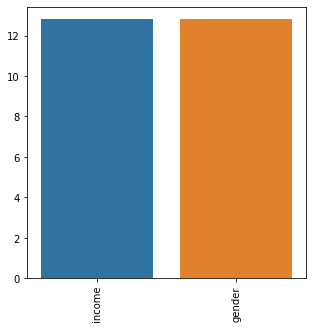

In [13]:
missing_values = (profile.isna().sum() * 100 / profile.shape[0]).sort_values(ascending=False)
plt.figure(figsize = (5,5))
sns.barplot(missing_values[missing_values > 0].index, missing_values[missing_values > 0].values)
plt.xticks(rotation = 'vertical')
plt.show()

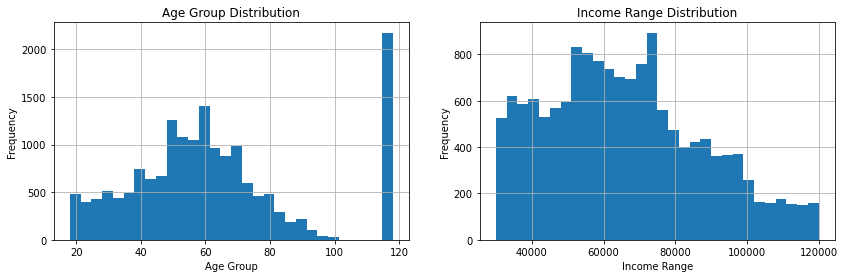

In [14]:
plt.figure(figsize = (14,4))
plt.subplot(1,2,1)
profile.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Age Group Distribution')

plt.subplot(1,2,2)
profile.income.hist(bins = 30);
plt.xlabel('Income Range')
plt.ylabel('Frequency')
plt.title('Income Range Distribution');

<AxesSubplot:title={'center':'Distribution of Gender'}>

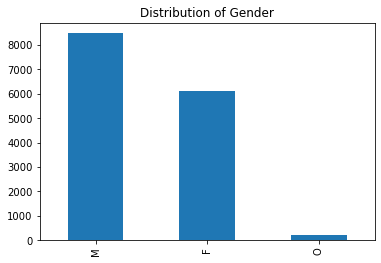

In [15]:
pd.value_counts(profile['gender']).plot.bar(title='Distribution of Gender')

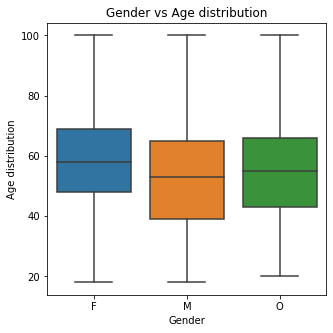

In [16]:
plt.figure(figsize = (5,5))
sns.boxplot(x=profile.gender, y =profile.age, data = profile, showfliers = False)
plt.title('Gender vs Age distribution')
plt.xlabel("Gender")
plt.ylabel("Age distribution")
plt.show()

**Observations**

* Income and age has the highest missing values out of all the columns in the dataset
* Some outlier age is present in the data which is more than 115
* The average age of users is between 50-62 years in the dataset
* Average income user is within the range 65000-70000
* With respect to gender, the highest observations are for Males followed by females in the dataset
* The median age for all genders is distributed within the range 55-60 in the data

#### Transcript Dataset

In [17]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [18]:
transcript.describe(include="all")

,person,event,value,time
count,306534,306534,306534,306534.000000
unique,17000,4,5121,NaN
top,94de646f7b6041228ca7dec82adb97d2,transaction,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},NaN
freq,51,138953,14983,NaN
mean,NaN,NaN,NaN,366.382940
std,NaN,NaN,NaN,200.326314
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,186.000000
50%,NaN,NaN,NaN,408.000000
75%,NaN,NaN,NaN,528.000000


<AxesSubplot:title={'center':'Distribution of Event Types'}>

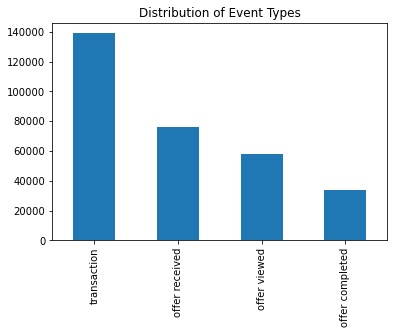

In [19]:
pd.value_counts(transcript['event']).plot.bar(title='Distribution of Event Types')

In [20]:
per_person_value = transcript[transcript['event'] == 'offer received'].groupby(['person'], as_index = False).agg({'value':'count'})
per_person_value.describe()

,value
count,16994.000000
mean,4.488467
std,1.073047
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,6.000000


**Observations**

* On an average, 4 offers were received at a user level
* The maximum number of offers received were 6 for a person
* The different types of events in the transcript dataseta are transaction, offer received, offer viewed and offer completed

### Data Cleaning

#### Portfolio

In [21]:
def rename_column(df, new_cols_name):
    """
    Input
    df: input dataframe for renaming columns
    new_cols_name: define new column name for each column
    
    Output
    df: output data frame with renamed column names
    """
    df= df.rename(columns = new_cols_name)
    return df

In [22]:
portfolio_renamed_cols = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
portfolio_renamed = rename_column(portfolio, portfolio_renamed_cols)

In [23]:
portfolio_renamed.head(2)

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


#### Profile

In [24]:
profile_renamed_cols = {'id':'customer_id' , 'income':'customer_income'}
profile_renamed = rename_column(profile, profile_renamed_cols)

In [25]:
profile_renamed.head(2)

,gender,age,customer_id,became_member_on,customer_income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [26]:
def profile_clean(df):
    """        
    Input   
    df: data frame
    
    Output
    df: output data frame cleaned for missing values and other inconsistencies
    """
    
    # Replace 118 age values with NaN and then in turn replace them with the mean of the age column
    df.replace(118, np.nan , inplace=True)
    
    # Replace NaN age values with average of the age column
    df['age'] = df['age'].fillna(df['age'].mean())
    
    # Replace missing income values with average of the income column
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    
    # Replace missing gender values with mode of the gender column
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    # Remove outliers from the age column and change the data type to int
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    # Convert the age column to categorical
    df.loc[(df.age < 20) , 'age_group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'age_group'] = '20-35'
    df.loc[(df.age >= 36) & (df.age <= 45) , 'age_group'] = '36-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df

In [27]:
profile_clean = profile_clean(profile_renamed)

<ipython-input-26-18dcb9dbd8d0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['age'] = df['age'].astype(int)
C:\Users\kashyap.barua\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\kashyap.barua\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [28]:
profile_clean.head(2)

,gender,customer_id,became_member_on,customer_income,age_group
0,M,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,46-60
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000,46-60


In [29]:
profile_clean.isnull().sum()

gender              0
customer_id         0
became_member_on    0
customer_income     0
age_group           0
dtype: int64

#### Transcript

In [30]:
transcript_renamed_cols = {'person':'customer_id'}
transcript_renamed = rename_column(transcript, transcript_renamed_cols)

In [31]:
transcript_renamed.tail(5)

,customer_id,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [32]:
def transcript_clean(df):
    """
    Input   
    df: data frame
    
    Output
    df: output data frame cleaned and parsed for the dictionary column 'value'
    """
    
    # Expand the dictionary based column to singular columns
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['money_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['money_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    # Move 'offer id' values into 'offer_id'
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    
    # Drop 'offer id' column 
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    
    # Replace NANs
    df.fillna(0 , inplace=True)
    
    return df

In [33]:
transcript_clean = transcript_clean(transcript_renamed)

In [34]:
transcript_clean.head(5)

,customer_id,event,time,offer_id,money_gained,money_spent
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


### Exploratory Data Analysis

Performing some EDA on the merged datasets after having cleaned for inconsistencies

In [35]:
merged_df = pd.merge(portfolio_renamed, transcript_clean, on='offer_id')
merged_df = pd.merge(merged_df, profile_clean, on='customer_id')

In [36]:
merged_df.head(5)

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,20170909,100000.0,61-80
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,20170909,100000.0,61-80
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,20170909,100000.0,61-80
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,20170909,100000.0,61-80


In [37]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 157502
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   offer_reward      157503 non-null  int64  
 1   channels          157503 non-null  object 
 2   offer_difficulty  157503 non-null  int64  
 3   offer_duration    157503 non-null  int64  
 4   offer_type        157503 non-null  object 
 5   offer_id          157503 non-null  object 
 6   customer_id       157503 non-null  object 
 7   event             157503 non-null  object 
 8   time              157503 non-null  int64  
 9   money_gained      157503 non-null  float64
 10  money_spent       157503 non-null  float64
 11  gender            157503 non-null  object 
 12  became_member_on  157503 non-null  int64  
 13  customer_income   157503 non-null  float64
 14  age_group         157503 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 19.2+ MB


Text(0.5, 1.0, 'Customer Income Distribution')

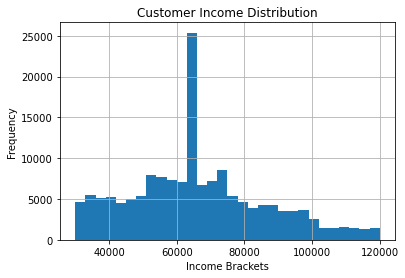

In [38]:
merged_df.customer_income.hist(bins = 30)
plt.xlabel('Income Brackets')
plt.ylabel('Frequency')
plt.title('Customer Income Distribution')

<AxesSubplot:title={'center':'Distribution of Offer Types'}>

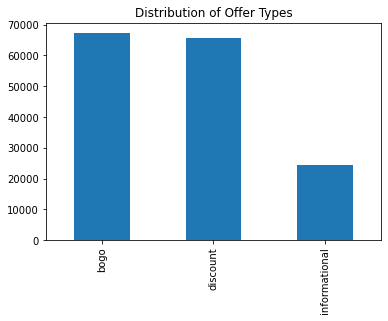

In [39]:
pd.value_counts(merged_df['offer_type']).plot.bar(title='Distribution of Offer Types')

<AxesSubplot:title={'center':'Distribution of Age Groups'}>

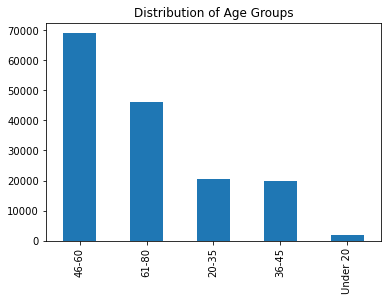

In [40]:
pd.value_counts(merged_df['age_group']).plot.bar(title='Distribution of Age Groups')

<AxesSubplot:title={'center':'Distribution of Offer Actions'}>

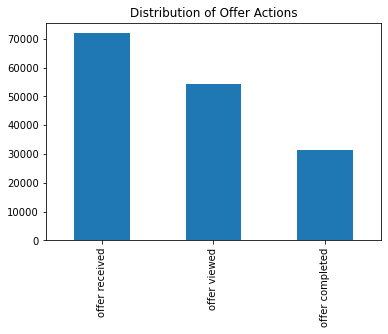

In [41]:
pd.value_counts(merged_df['event']).plot.bar(title='Distribution of Offer Actions')

**Observations**

* In the offer type section of the dataset, BOGO and Discount are the most frequent
* It is seen that the most engagement is within the age groups 46-60 followed by 61-80, i.e., anyone above the age 46 is highly engaging with our brand
* It is observed that the conversion from offer received to offer completed is roughly about 42% of all that received offers

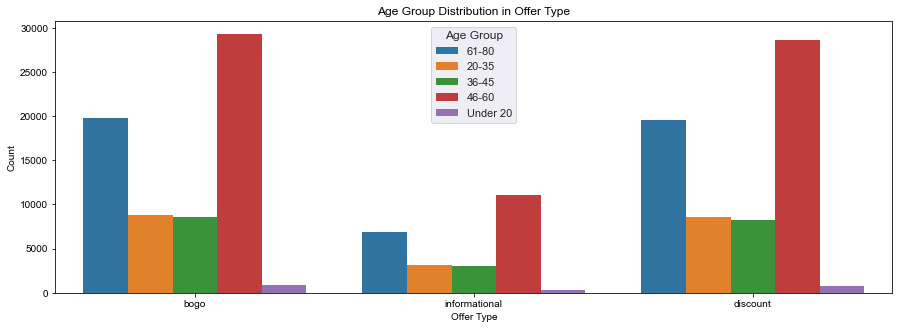

In [42]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "age_group", data=merged_df)
sns.set(style="darkgrid")
plt.title('Age Group Distribution in Offer Type')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Age Group')

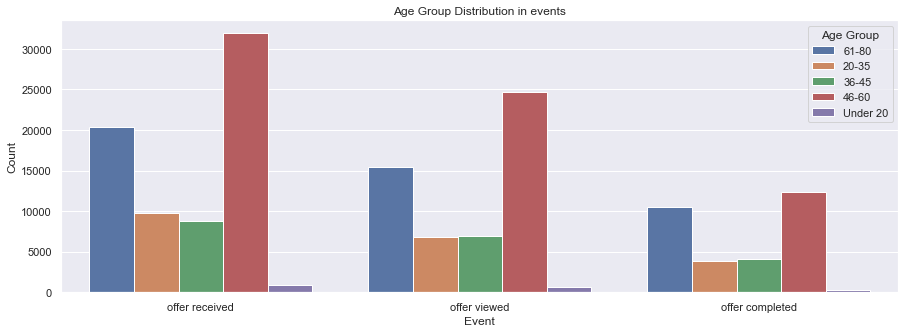

In [43]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "age_group", data=merged_df)
sns.set(style="darkgrid")
plt.title('Age Group Distribution in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Age Group')

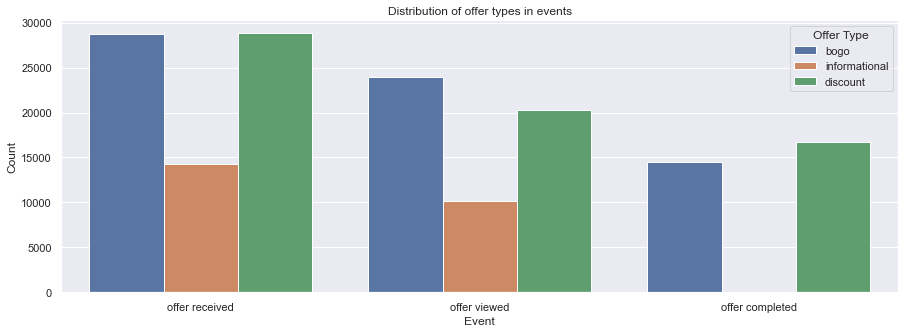

In [44]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=merged_df)
sns.set(style="darkgrid")
plt.title('Distribution of offer types in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

**Observations**

* Again, age group equal and above 46 are the ones most engaged in terms of any sort of offers
* Even for the event engagement with the offers, the highest activity is prominent in this age group, while under 20 is the least active. This indicates that the adult and senior citizens are the most engaging with any programs that Starbucks has to roll out
* The funnel from offer received to offer completed looks promising for Bogo offers followed by discounts, while informational offers do not see any offer completions at all

### Machine Learning Model

We build a machine learning model to predict the response of a customer to an offer.

#### Clean the data for modeling

In [45]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [46]:
merged_df.head()

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,20170909,100000.0,61-80
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,20170909,100000.0,61-80
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,20170909,100000.0,61-80
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,20170909,100000.0,61-80


In [47]:
merged_df.columns

Index(['offer_reward', 'channels', 'offer_difficulty', 'offer_duration',
       'offer_type', 'offer_id', 'customer_id', 'event', 'time',
       'money_gained', 'money_spent', 'gender', 'became_member_on',
       'customer_income', 'age_group'],
      dtype='object')

In [48]:
def clean_data(df):
    """
    Input   
    df: data frame
    
    Output
    df: cleaned data frame with the below steps
    """
    # One-hot encode categorical features
    cat_features = ['offer_type', 'gender', 'age_group']
    df = pd.get_dummies(df, columns = cat_features)
    
    # Separate the channels in the channel column and transfor using one-hot encoding
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    # Change data type of required features
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    
    # Extract month and year from became_member_on column
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    
    # Drop original feature
    df.drop('became_member_on',axis=1, inplace=True)
    
    # Fix the offer_id feature
    offerid_list = df['offer_id'].unique().tolist()
    offer_mapping = dict(zip(offerid_list, range(len(offerid_list))) )
    df.replace({'offer_id': offer_mapping}, inplace=True)
    
    # Fix customer_id feature
    customer_ids = df['customer_id'].unique().tolist()
    customer_mapping = dict(zip(customer_ids,range(len(customer_ids))) )
    df.replace({'customer_id': customer_mapping}, inplace=True)
    
    # Scale the continuous features
    scaler = MinMaxScaler()
    num_features = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 
                    'time', 'money_gained', 'money_spent']
    df[num_features] = scaler.fit_transform(df[num_features])
    
    # Encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df

In [49]:
final_df = clean_data(merged_df)

In [50]:
final_df.head()

,offer_reward,offer_difficulty,offer_duration,offer_id,customer_id,event,time,money_gained,money_spent,customer_income,...,age_group_36-45,age_group_46-60,age_group_61-80,age_group_Under 20,email,mobile,social,web,month_member,year_member
0,1.0,0.5,0.571429,0,0,1,0.000000,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
1,1.0,0.5,0.571429,0,0,2,0.142857,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
2,1.0,0.5,0.571429,0,0,1,0.705882,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
3,1.0,0.5,0.571429,0,0,2,0.714286,0.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017
4,1.0,0.5,0.571429,0,0,3,0.714286,1.0,0.0,0.777778,...,0,0,1,0,1,1,1,0,9,2017


In [51]:
final_df.shape

(157503, 27)

In [52]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 157502
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   offer_reward              157503 non-null  float64
 1   offer_difficulty          157503 non-null  float64
 2   offer_duration            157503 non-null  float64
 3   offer_id                  157503 non-null  int64  
 4   customer_id               157503 non-null  int64  
 5   event                     157503 non-null  int64  
 6   time                      157503 non-null  float64
 7   money_gained              157503 non-null  float64
 8   money_spent               157503 non-null  float64
 9   customer_income           157503 non-null  float64
 10  offer_type_bogo           157503 non-null  uint8  
 11  offer_type_discount       157503 non-null  uint8  
 12  offer_type_informational  157503 non-null  uint8  
 13  gender_F                  157503 non-null  u

#### Split to Train and Test set

In [53]:
data = final_df.drop('event', axis=1)
label = final_df['event']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, random_state = 7)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 126002 rows
Testing set: 31501 rows


In [55]:
def scores(clf):
    """
    Train and Test F1 score along with the model name
     
    Input
    clf: Estimator Instance
    
    Output
    Train data F1 score
    Test data F1 score
    Model name
       
    """
    train_prediction = (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction) * 100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro') * 100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

#### K Neighbors Classifier

In [56]:
KNeighbors_clf = KNeighborsClassifier(n_neighbors = 3)
KNeighbors_train_f1, KNeighbors_test_f1, KNeighbors_model = scores(KNeighbors_clf)

In [57]:
knn = {'Benchmark Model': [KNeighbors_model], 'train F1 score':[KNeighbors_train_f1], 'test F1 score': [KNeighbors_test_f1]}
benchmark = pd.DataFrame(knn)

In [58]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,55.837209,25.80553


#### Decision Tree Classifier

In [92]:
DecisionTree_clf = DecisionTreeClassifier(random_state = 10)
DecisionTree_train_f1, DecisionTree_test_f1, DecisionTree_model = scores(DecisionTree_clf)

In [93]:
dtc = {'Benchmark Model': [DecisionTree_model], 'Train F1 score':[DecisionTree_train_f1], 'Test F1 score': [DecisionTree_test_f1]}
benchmark = pd.DataFrame(dtc)

In [94]:
benchmark

,Benchmark Model,Train F1 score,Test F1 score
0,DecisionTreeClassifier,93.983429,84.683026


#### Random Forest Classifier

In [62]:
RandomForest_clf = RandomForestClassifier(random_state = 10)
RandomForest_train_f1, RandomForest_test_f1, RandomForest_model = scores(RandomForest_clf)

In [63]:
rfc = {'Benchmark Model': [RandomForest_model], 'Train F1 score':[RandomForest_train_f1], 'Test F1 score': [RandomForest_test_f1]}
benchmark = pd.DataFrame(rfc)

In [64]:
benchmark

,Benchmark Model,Train F1 score,Test F1 score
0,RandomForestClassifier,93.983429,67.556586


In [65]:
LogisticRegression_clf = LogisticRegression(random_state = 10)
LogisticRegression_train_f1, LogisticRegression_test_f1, LogisticRegression_model = scores(LogisticRegression_clf)

C:\Users\kashyap.barua\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kashyap.barua\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

In [66]:
lr = {'Benchmark Model': [LogisticRegression_model], 'Train F1 score':[LogisticRegression_train_f1], 'Test F1 score': [LogisticRegression_test_f1]}
benchmark = pd.DataFrame(lr)

In [67]:
benchmark

,Benchmark Model,Train F1 score,Test F1 score
0,LogisticRegression,47.287345,47.392146


In [68]:
model_combined = {'Model': ['KNeighborsClassifier (Benchmark)', DecisionTree_model, RandomForest_model, LogisticRegression_model], 
          'Train F1 score ':[KNeighbors_train_f1, DecisionTree_train_f1, RandomForest_train_f1, LogisticRegression_train_f1], 
          'Test F1 score': [KNeighbors_test_f1 , DecisionTree_test_f1, RandomForest_test_f1, LogisticRegression_test_f1] }
          
model_comparison = pd.DataFrame(model_combined)

In [69]:
model_comparison

,Model,Train F1 score,Test F1 score
0,KNeighborsClassifier (Benchmark),55.837209,25.805530
1,DecisionTreeClassifier,93.983429,84.683026
2,RandomForestClassifier,93.983429,67.556586
3,LogisticRegression,47.287345,47.392146


#### Hyperparameter Tuning and model improvement

In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_features': ['auto', 'sqrt'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
DecisionTree_clf = DecisionTreeClassifier(random_state=10)
grid_search = GridSearchCV(estimator = DecisionTree_clf, param_grid = param_grid, cv = 5, verbose = True)

# Fit the model using Grid Search
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=10),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt']},
             verbose=True)

In [83]:
final_model = grid_search.best_estimator_
final_model

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=8,
                       max_features='auto', random_state=10)

In [84]:
#Training the model with best estimators
DecisionTree_clf = DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=10, splitter='best')

# DecisionTree_clf.fit(X_train, y_train)
# y_predict = tree_clas.predict(x_test)

DecisionTree_train_f1, DecisionTree_test_f1, DecisionTree_model = scores(DecisionTree_clf)

In [91]:
dtc = {'Benchmark Model': [DecisionTree_model], 'Train F1 score':[DecisionTree_train_f1], 'Test F1 score': [DecisionTree_test_f1]}
benchmark = pd.DataFrame(dtc)
benchmark

,Benchmark Model,Train F1 score,Test F1 score
0,DecisionTreeClassifier,62.550594,62.471033


Using Feature Importance based on mean decrease in impurity using the Random Forest Classifier that we constructed above to understand the best features available in the dataset

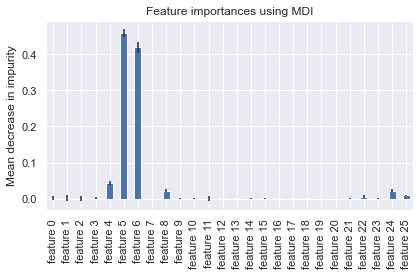

In [105]:
importances = RandomForest_clf.feature_importances_
feature_names = [f'feature {i}' for i in range(X_train.shape[1])]
importances = RandomForest_clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in RandomForest_clf.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Results

* The test set has been used to evaluate the model performances. K Neighbours was set as the benchmark model and the other model scores were compared to the same
* Decision Tree Classifier had the best validation F1 score of all (84.6%) while the benchmark was only 25%
* While the Random Forest Classifier had a remarkable 93% on the Train set, the scores for the validation set turned out to be 67% only
* Even though there has been variabilities in the F1 scores for Train and Test sets, it is still fine to use the models to predict if a customer will respond to an offer or not
* We can further use hyper-parameter tuning to improve on the scores, as future scope of this project
* Features 4,5,6 are the best features suggested by the Random Forest Classifier for our model